<a href="https://colab.research.google.com/github/isdrael4590/DIALUNG/blob/main/notebooks/cargarDatasetColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plantilla para cargar el Dataset en Colab

Los atributos acordados a usar para el filtrado de los datasets son:

- Imágenes con resolución mayor a `(200, 200)`
- Formato vertical
- Posterior Anterior
- Imágenes con condición de Tuberculosis, Neumonia, COVID-19 y normal
- Si tiene una condición adyacente, unirla igualmente(Infusiones, Atelectasis, etc.)

## Formato DIALUNG

El dataset filtrado debe estar en formato DIALUNG, es decir
- Primera  columna: `Ruta de la imagen`
- Segunda columna: `Condición en  Formato Matemático`

Condiciones en formato matematico
```python
condiciones_formato_matematico = {
    0: "normal",
    1: "tuberculosis",
    2: "neumonia",
    3: "covid-19"
}
```

**Ejemplo formato DIALUNG:**

|image_name                    |condition |
|:----------------------------:|:-------:|
| Dataset_1/CHNCXR_0025_0.png  |    0    |
| Dataset_1/CHNCXR_0270_0.png  |    0    |
| Dataset_1/CHNCXR_0055_0.png  |    0    |
| Dataset_1/CHNCXR_0410_1.png  |    1    |
| Dataset_1/CHNCXR_0076_0.png  |    0    |
| Dataset_1/CHNCXR_0645_1.png  |    1    |


## Nombre de los archivos que contienen los atributos del dataset

- `train.csv` 75% de los datos totales, fuente única de entrenamiento
- `test.csv` 15% de los datos totales, fuente para validar el modelo
- `val.csv`  10% de los datos totales, fuente para tunear los hiperparámetros



# Cargar los datos del Dataset
## Inicializar librerias

In [1]:
import numpy as np
import pandas as pd
import os
mapa_condiciones = {
    0: "normal",
    1: "tuberculosis",
    2: "neumonia",
    3: "covid-19"
}

## Instalar la librería TorchIO
Librería para la manipulación y aumentación de imágenes médicas, link [TorchIO](https://github.com/fepegar/torchio)

In [2]:
!pip install torchio

## Código de carga del dataset
### Abrir la cuenta de Google

Primero que todo, hay que dar acceso a la cuenta de Google que almacena el Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Cambiar de directorio
Cambiamos de directorio, hacia la carpeta que contiene el Dataset

In [4]:
%cd /content/drive/My\ Drive/ProyectoDIALUNG/

/content/drive/My Drive/ProyectoDIALUNG


## Cargar los archivos pandas


In [5]:
direccion_dataset_imagenes = "DIALUNG-Datasets/"
dataset_train = pd.read_csv(os.path.join(direccion_dataset_imagenes, "train.csv"), index_col = 0) #Cargo el archivo de train y el index es la primera columna
dataset_test = pd.read_csv(os.path.join(direccion_dataset_imagenes, "test.csv"), index_col = 0)
dataset_val = pd.read_csv(os.path.join(direccion_dataset_imagenes, "val.csv"), index_col = 0)


## Verificar los archivos pandas (Opcional)
Este código verifica el número y la existencia de los archivos de los datasets y que cumplan en formato DIALUNG

In [6]:
#@title Verificar los elementos del dataset, ejecutar si hay un error con el dataset

def verificar_dataset(df_dataset, nombre):
  condiciones_formato_matematico = mapa_condiciones.keys()
  novedades = False
  for elemento in df_dataset.iterrows():
    #Compruebo que el elemento esté en la carpeta
    elemento = elemento[1]
    ruta_elemento = os.path.join(direccion_dataset_imagenes, elemento["image_name"])
    if not os.path.exists(ruta_elemento):
      novedades = True
      print("Elemento {} no existe en el directorio {} por favor, verifique antes de cargar el DataLoader".format(elemento["image_name"], ruta_elemento))
    #Compruebo que la condicion sea valida
    if not int(elemento["condition"]) in condiciones_formato_matematico:
      print("Elemento {} tiene mal asignada la condicion, verifique antes de cargar al DataLoader".format(elemento))
      novedades = True
  if novedades:
    print("El DataFrame {} presenta novedades".format(nombre))
  else:
    print("La verificación del DataFrame {} ha concluido exitosamente sin errores".format(nombre))

verificar_dataset(dataset_train, "train")
verificar_dataset(dataset_test, "test")
verificar_dataset(dataset_val, "val")

dataset_train["condition"].plot.bar()

La verificación del DataFrame train ha concluido exitosamente sin errores
La verificación del DataFrame test ha concluido exitosamente sin errores
La verificación del DataFrame val ha concluido exitosamente sin errores


Error in callback <function flush_figures at 0x7f8dde3ae320> (for post_execute):


KeyboardInterrupt: ignored

## Crear el la clase Dataset de tipo PyTorch Dataset
Crea el dataset en formato Torch.data.Dataset, no hace falta modificar esta clase, solo ejecutarla

In [93]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets, io
from torchvision.transforms import Compose


class crearDatasetDIALUNG(Dataset):
    """
    Una clase que hereda los clase torch.utils.data.Dataset para crear un objeto que pueda ser 
    manipulado por la clase DataLoader de PyTorch
    ...

    Atributos
    ----------
    img_labels : pandas.DataFrame
        un objeto de tipo pandas.Dataframe que tiene dos columnas, la primera nombre de la imagen y segunda condicion
    img_dir : str
        Directorio de las imagenes de los datasets
    transform : torchvision.transforms
        Transformaciones de formato PyTorch para aplicar las imagenes
    target_transform : int
        Especifica las transformaciones de la etiqueta y características

    Métodos
    -------
    __len__(self)
        Devuelve el tamaño del dataframe
    """
    def __init__(self, pandas_file, img_dir, transform=None, target_transform=None):
        """
        Parámetros
        ----------
        pandas_file : pandas.DataFrame
            un objeto de tipo pandas.Dataframe que tiene dos columnas, la primera nombre de la imagen y segunda condicion
        img_dir : str
            Directorio de las imagenes de los datasets
        transform : torchvision.transforms
            Transformaciones de formato PyTorch para aplicar las imagenes
        target_transform : int
            Especifica las transformaciones de la etiqueta y características

        """
        self.img_labels = pandas_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """
        Devuelve
        ----------
        int 
            El tamaño del DataFrame en entero
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """Obtiene la imagen del idx del dataset, lee en formato Tensor, aplica las transformaciones
        y devuelve una imagen y su etiqueta.
        Parámetros
        ----------
        idx : int
            índice secuencial de la imagen que se localiza en el DataFrame
        Devuelve
        ----------
        torch.Tensor
            La imagen en formato tensor de PyTorch en Escala de Grises (Tensor[1, alto_imagen, ancho_imagen])
        int 
            La etiqueta correspondiente de la imagen
        """
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) #Busco el nombre de la imagen en la columna cero
        image = read_image(img_path, io.image.ImageReadMode.GRAY) #transformo mi imagen directamente a Escala de grises
        label = self.img_labels.iloc[idx, 1] #Busco el nombre de la etiqueta el DataFrame
        image = torch.unsqueeze(image, 3) ## Añade una dimensión al vector 4D
        if self.transform: #Aplico transformacion(es) de la imagen
            image = self.transform(image)
        if self.target_transform: #Aplico transformacion(es) a los labels
            label = self.target_transform(label)
        #image = torch.reshape(image, (capas_imagen, alto_imagen, ancho_imagen, 1))#Formato TORCHIO Tensor 4D
        return image, label

## Crear los objetos de tipo crearDatasetDIALUNG que definimos anteriormente
Sino se ha cambiado ninguna variable, solo faltaría añadir transformaciones si se necesitan, además del formato [one-hot-encode](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

### Aumentaciones acordadas
- Crop
- Rotations
- Blur
- Noise
- Desplazamiento

### Parámetros de aumentación
Definir aquí los parámetros de aumentación y de dataset

In [89]:
#Tamaño deseado de la imagen
ancho_imagen_deseado  = 256
alto_imagen_deseado =  256
#Variables de rotación
probabilidad_rotacion = 0.15
angulo_rotacion_grados = 15
#Variables de Blur
probabilidad_blur = 0.15
std_filtro_gaussiano = (2, 2)
#Variables de Ruido
probabilidad_ruido = 0.15
std_ruido_gaussiano = (0, 0.25)
mean_ruido_gaussiano = 0
# Variables de Desplazamiento
probabilidad_desplazamiento = 0.15
desplazamiento_x_y = (1, 1) #1 mm de desplazamiento en ambos ejes 
# Tamaño del batch
batch_size = 16

Aplicación de las operaciones de aumentación

In [98]:

from torchvision.transforms import Compose #Compose me sirve para apilar varias transformaciones en una sola
from torchvision.transforms import Resize #Cargar herramienta para hacer Rescalado
from torchvision.transforms import Lambda #Convertir tensor de salida a one-hot-encoded 
import torch 
#Librerias de TorchIO
import torchio as tio

resize_transform = tio.Resize((alto_imagen_deseado, ancho_imagen_deseado, 1)) #Cambiar el tamaño al establecido en la celda de arriba
#Diccionario de transformaciones con su probabilidad de ser ejecutadas
diccionario_transformaciones = {
  tio.RandomAffine(degrees = angulo_rotacion_grados): probabilidad_rotacion, #transformacion de rotación  
  tio.transforms.RandomBlur(std = std_filtro_gaussiano): probabilidad_blur, #transformacion de blur  
  tio.transforms.RandomNoise(mean = mean_ruido_gaussiano, std = std_ruido_gaussiano): probabilidad_ruido, #transformaciones de ruido
  #tio.RandomAffine(translation = desplazamiento_x_y): probabilidad_desplazamiento #transformacion de traslación 
}
#Agrupar todas las transformaciones en una sola
transformaciones_DIALUNG = tio.OneOf(diccionario_transformaciones)

transformaciones_dataset = Compose([resize_transform, transformaciones_DIALUNG]) #Apila las transformaciones
transformacion_salida = Lambda(lambda y: torch.zeros(4, dtype=torch.float).scatter_(0, torch.tensor(int(y)), value=1)) #Hago un

#Creo objetos de tipo crearDatasetDIALUNG
train_datasetDIALUNG = crearDatasetDIALUNG(dataset_train, direccion_dataset_imagenes, transformaciones_dataset, transformacion_salida)
test_datasetDIALUNG = crearDatasetDIALUNG(dataset_test, direccion_dataset_imagenes, transformaciones_dataset, transformacion_salida)
val_datasetDIALUNG = crearDatasetDIALUNG(dataset_val, direccion_dataset_imagenes, transformaciones_dataset, transformacion_salida)

## Definir los objetos tipo DataLoader de tamaño de 64 imagenes
Solo carga los objetos anteriores, en un formato que se puede iterar en PyTorch

In [99]:
from torch.utils.data import DataLoader #Clase dataloader para cargar en PyTorch los objetos de tipo Dataset

#Creo objetos de tipo DataLoader en lotes de 64 imagenes y barajeados aleatoriamente
train_dataloader = DataLoader(train_datasetDIALUNG, batch_size=batch_size, shuffle=True, num_workers =  0)
test_dataloader = DataLoader(test_datasetDIALUNG, batch_size=batch_size, shuffle=True, num_workers = 0)
val_dataloader = DataLoader(val_datasetDIALUNG, batch_size=batch_size, shuffle=True, num_workers = 0)

## Verificacion del Dataset de Val
Se verifica el Dataset de validación porque es el más pequeño y demora menos en cargar

Feature batch shape: torch.Size([16, 1, 256, 256, 1])
Labels batch shape: torch.Size([16, 4])


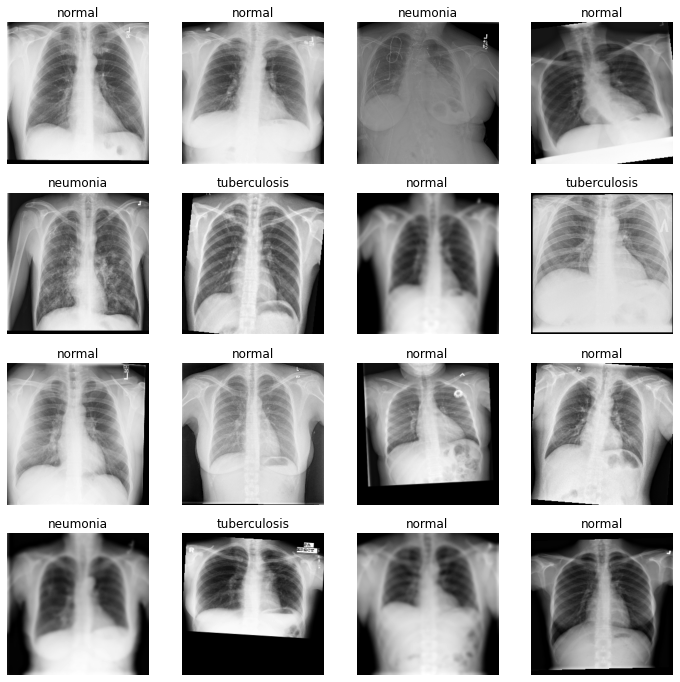

In [100]:
import matplotlib.pyplot as plt
# Display image and label.
figure = plt.figure(figsize=(12, 12))
cols, rows = 4, 4
train_features, train_labels = next(iter(val_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
for i in range(1, cols * rows + 1):
  img = train_features[i-1].squeeze()
  label = mapa_condiciones[int(torch.argmax(train_labels[i-1]))]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img, cmap="gray")
plt.show()


# Funciones para entrenamiento
## A partir de aquí se puede definir el modelo de red


In [97]:
### A partir de aqui definir el modelo de RED